# Intial commands

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pavelstatsutils
%matplotlib inline

In [2]:
patients = pd.read_csv("patients.csv")
controls = pd.read_csv("controls.csv")

In [3]:
df = pd.concat([patients, controls])
df.head()

,PATIENT,age,gender,SN_area,SN_index,3rd_ventricle
0,1,64,1,0.11,25.68,7.6
1,1,74,1,0.09,32.65,5.7
2,1,66,1,0.21,33.91,6.4
3,1,73,1,0.32,29.05,6.8
4,1,69,1,0.05,25.32,4.2


# Descriptional statistics

## Whole sample

In [4]:
df.describe()

,PATIENT,age,gender,SN_area,SN_index,3rd_ventricle
count,97.000000,97.000000,97.000000,97.000000,97.000000,96.000000
mean,0.505155,64.350515,0.845361,0.108247,23.947010,6.752083
std,0.502571,9.209417,0.363439,0.074568,8.602655,2.427777
min,0.000000,38.000000,0.000000,0.020000,7.380000,1.700000
25%,0.000000,59.000000,1.000000,0.060000,17.880000,4.775000
50%,1.000000,65.000000,1.000000,0.090000,22.460000,6.750000
75%,1.000000,70.000000,1.000000,0.120000,29.500000,8.500000
max,1.000000,85.000000,1.000000,0.360000,50.500000,11.800000


## Patients

In [5]:
df.loc[df['PATIENT'] == 1].describe()

,PATIENT,age,gender,SN_area,SN_index,3rd_ventricle
count,49.0,49.000000,49.000000,49.000000,49.000000,48.000000
mean,1.0,65.734694,0.959184,0.134898,25.730816,6.827083
std,0.0,8.390907,0.199915,0.088556,9.469470,2.374397
min,1.0,38.000000,0.000000,0.030000,7.380000,2.400000
25%,1.0,63.000000,1.000000,0.080000,18.650000,5.025000
50%,1.0,66.000000,1.000000,0.110000,25.320000,6.600000
75%,1.0,70.000000,1.000000,0.200000,32.650000,8.875000
max,1.0,83.000000,1.000000,0.360000,50.500000,11.500000


## Controls

In [6]:
df.loc[df['PATIENT'] == 0].describe()

,PATIENT,age,gender,SN_area,SN_index,3rd_ventricle
count,48.0,48.000000,48.000000,48.000000,48.000000,48.000000
mean,0.0,62.937500,0.729167,0.081042,22.126042,6.677083
std,0.0,9.863766,0.449093,0.043036,7.271720,2.502870
min,0.0,39.000000,0.000000,0.020000,10.680000,1.700000
25%,0.0,55.750000,0.000000,0.050000,16.557500,4.500000
50%,0.0,63.500000,1.000000,0.080000,21.060000,7.300000
75%,0.0,69.000000,1.000000,0.100000,25.560000,8.500000
max,0.0,85.000000,1.000000,0.220000,38.950000,11.800000


# Plotting data

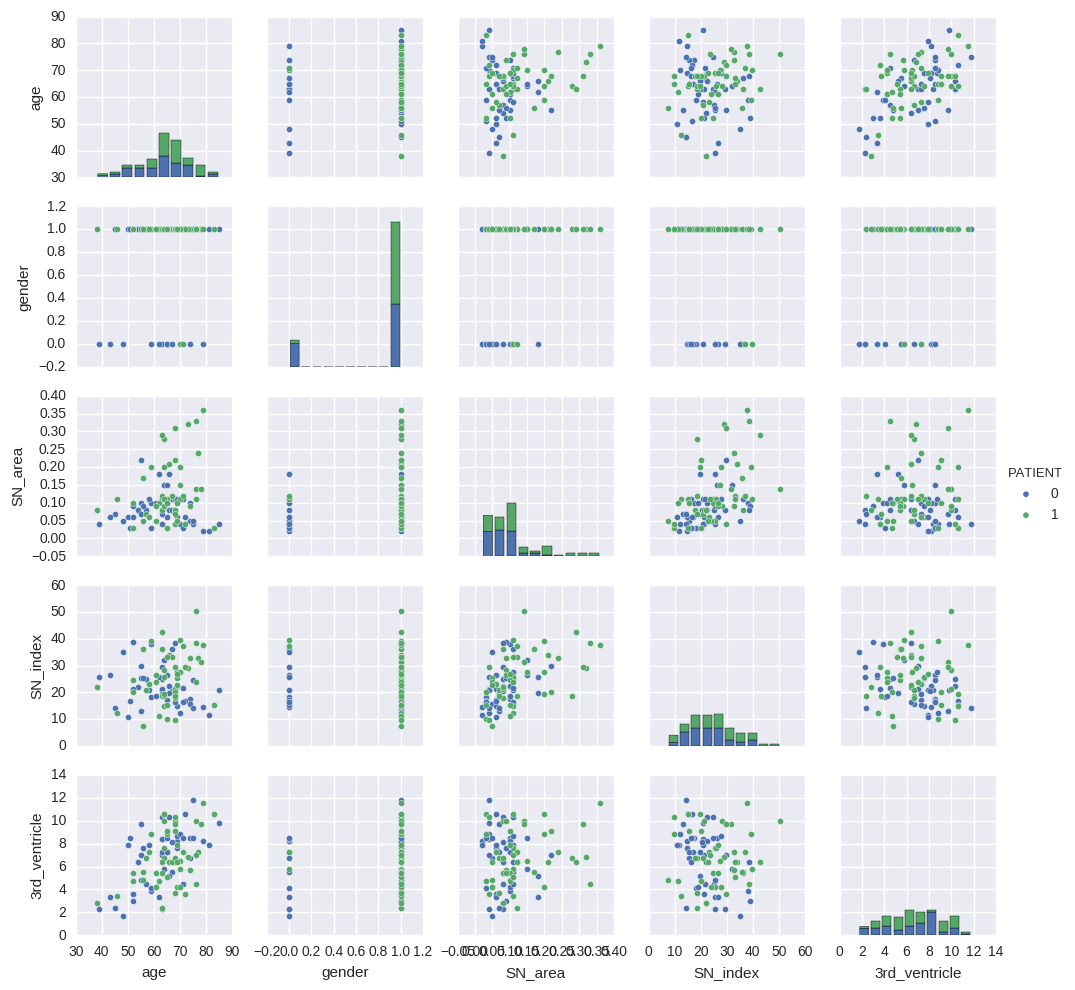

In [7]:
sns.pairplot(df.dropna(how='any'), vars=[x for x in df.columns if x!='PATIENT'], hue="PATIENT", size=2)

# Correlations

## Whole sample correlation

In [8]:
corr_r, corr_p, corr_b = pavelstatsutils.corr(df)


In [9]:
corr_r

,3rd_ventricle,PATIENT,SN_area,SN_index,age,gender
3rd_ventricle,1.000000,0.031055,0.084081,-0.167351,0.519212,0.229040
PATIENT,0.031055,1.000000,0.362977,0.210592,0.152647,0.318072
SN_area,0.084081,0.362977,1.000000,0.450185,0.171549,0.208983
SN_index,-0.167351,0.210592,0.450185,1.000000,0.072416,-0.046826
age,0.519212,0.152647,0.171549,0.072416,1.000000,0.081719
gender,0.229040,0.318072,0.208983,-0.046826,0.081719,1.000000


In [10]:
corr_p

,3rd_ventricle,PATIENT,SN_area,SN_index,age,gender
3rd_ventricle,0.000000e+00,0.763904,0.415375,0.103159,5.960148e-08,0.024790
PATIENT,7.639037e-01,0.000000,0.000258,0.038407,1.355238e-01,0.001499
SN_area,4.153752e-01,0.000258,0.000000,0.000004,9.292982e-02,0.039946
SN_index,1.031586e-01,0.038407,0.000004,0.000000,4.808742e-01,0.648779
age,5.960148e-08,0.135524,0.092930,0.480874,0.000000e+00,0.426185
gender,2.478999e-02,0.001499,0.039946,0.648779,4.261850e-01,0.000000


In [11]:
corr_b

,3rd_ventricle,PATIENT,SN_area,SN_index,age,gender
3rd_ventricle,True,False,False,False,True,False
PATIENT,False,True,True,False,False,True
SN_area,False,True,True,True,False,False
SN_index,False,False,True,True,False,False
age,True,False,False,False,True,False
gender,False,True,False,False,False,True


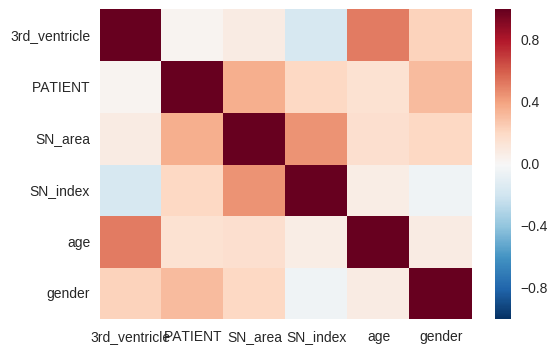

In [12]:
sns.heatmap(corr_r)

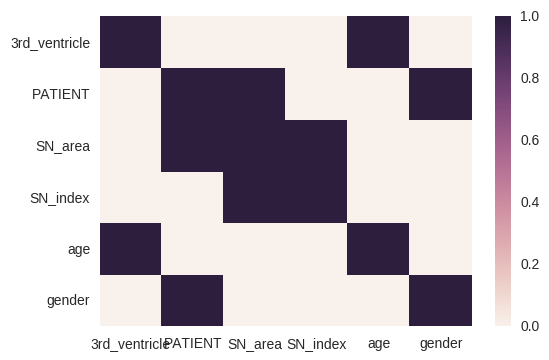

In [13]:
sns.heatmap(corr_b)

## Patients correlations

In [14]:
pat_corr_r, pat_corr_p, pat_corr_b = pavelstatsutils.corr(df.loc[df['PATIENT'] == 1].drop(['PATIENT'], axis=1))

In [15]:
pat_corr_r

,3rd_ventricle,SN_area,SN_index,age,gender
3rd_ventricle,1.000000,0.210057,0.040944,0.437339,0.024590
SN_area,0.210057,1.000000,0.426215,0.270940,0.046831
SN_index,0.040944,0.426215,1.000000,0.316249,-0.278737
age,0.437339,0.270940,0.316249,1.000000,-0.118366
gender,0.024590,0.046831,-0.278737,-0.118366,1.000000


In [16]:
pat_corr_p

,3rd_ventricle,SN_area,SN_index,age,gender
3rd_ventricle,0.000000,0.151857,0.782312,0.001882,0.868235
SN_area,0.151857,0.000000,0.002261,0.059699,0.749325
SN_index,0.782312,0.002261,0.000000,0.026846,0.052450
age,0.001882,0.059699,0.026846,0.000000,0.417927
gender,0.868235,0.749325,0.052450,0.417927,0.000000


In [17]:
pat_corr_b

,3rd_ventricle,SN_area,SN_index,age,gender
3rd_ventricle,True,False,False,True,False
SN_area,False,True,True,False,False
SN_index,False,True,True,False,False
age,True,False,False,True,False
gender,False,False,False,False,True


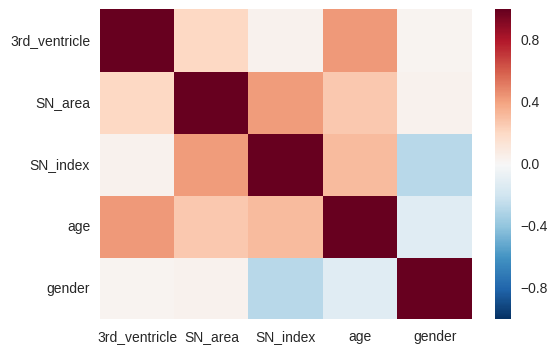

In [18]:
sns.heatmap(pat_corr_r)

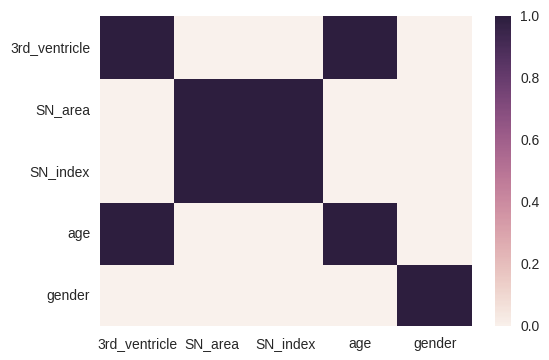

In [19]:
sns.heatmap(pat_corr_b)

## Controls correlations

In [20]:
con_corr_r, con_corr_p, con_corr_b = pavelstatsutils.corr(df.loc[df['PATIENT'] == 0].drop(['PATIENT'], axis=1))

In [21]:
con_corr_r

,3rd_ventricle,SN_area,SN_index,age,gender
3rd_ventricle,1.000000,-0.160366,-0.455891,0.589949,0.338869
SN_area,-0.160366,1.000000,0.398432,-0.100589,0.224073
SN_index,-0.455891,0.398432,1.000000,-0.266936,-0.057539
age,0.589949,-0.100589,-0.266936,1.000000,0.096963
gender,0.338869,0.224073,-0.057539,0.096963,1.000000


In [22]:
con_corr_p

,3rd_ventricle,SN_area,SN_index,age,gender
3rd_ventricle,0.000000,0.276231,0.001129,0.000010,0.018471
SN_area,0.276231,0.000000,0.005034,0.496341,0.125759
SN_index,0.001129,0.005034,0.000000,0.066643,0.697679
age,0.000010,0.496341,0.066643,0.000000,0.512070
gender,0.018471,0.125759,0.697679,0.512070,0.000000


In [23]:
con_corr_b

,3rd_ventricle,SN_area,SN_index,age,gender
3rd_ventricle,True,False,True,True,False
SN_area,False,True,True,False,False
SN_index,True,True,True,False,False
age,True,False,False,True,False
gender,False,False,False,False,True


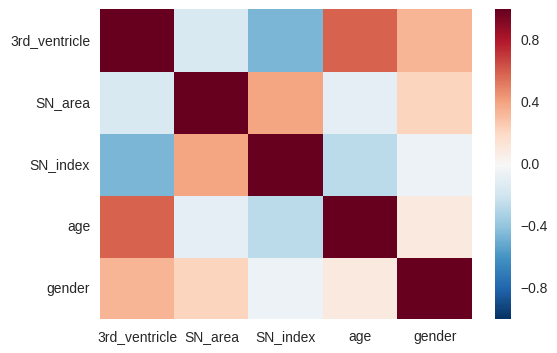

In [24]:
sns.heatmap(con_corr_r)

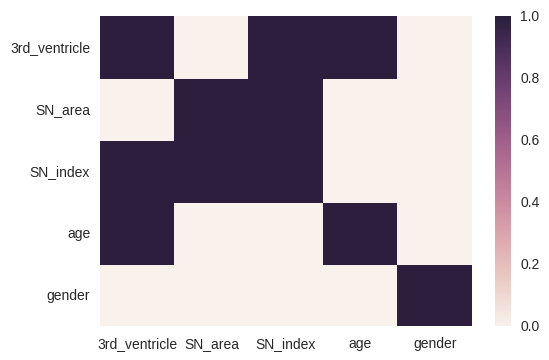

In [25]:
sns.heatmap(con_corr_b)

## Comparison of patients and groups in significant correlations

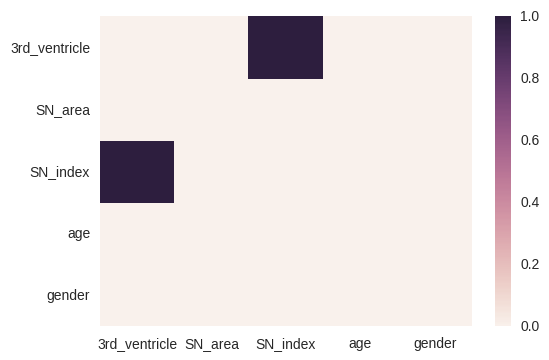

In [26]:
sns.heatmap( pat_corr_b ^ con_corr_b )

# Group comparisons

## Plots

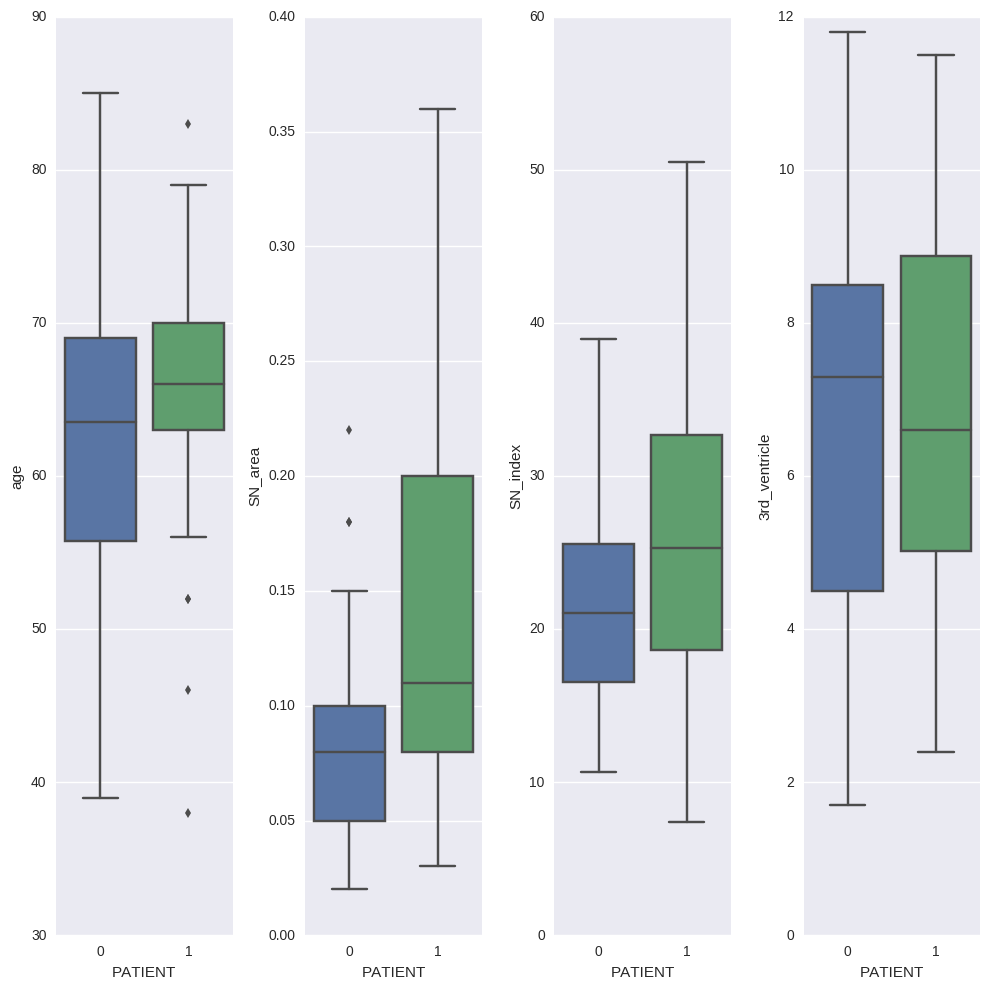

In [27]:
f, axes = plt.subplots(1, len(df.columns)-2, figsize=(10, 10), sharex=True)
i = 0
for column in df.columns:
    if column != "PATIENT" and column != "gender":
        sns.boxplot(x="PATIENT", y=column, data=df, ax=axes[i])
        i = i + 1
#plt.setp(axes, yticks=[])
plt.tight_layout()

## Parametric testing prerequisities

Shapiro: Shapiro-Wilk's test for normality.

Levene: Levene's test for homoscedasticity.

In [28]:
prereq = {}
prereq_p = {}
for column in df.columns:
    if column != 'PATIENT':
        prereq_p[column] = []
        prereq[column] = []
        
        #All Normality Shapiro-Wilk test
        W, p = scipy.stats.shapiro(df[column].dropna())
        normality = p > 0.05
        prereq_p[column].append(p)
        prereq[column].append(normality)
        
        #Patients Normality Shapiro-Wilk test
        W, p = scipy.stats.shapiro(df.loc[df['PATIENT'] == 1, column].dropna())
        normality = p > 0.05
        prereq_p[column].append(p)
        prereq[column].append(normality)

        #Controls Normality Shapiro-Wilk test
        W, p = scipy.stats.shapiro(df.loc[df['PATIENT'] == 0, column].dropna())
        normality = p > 0.05
        prereq_p[column].append(p)
        prereq[column].append(normality)

        #Patients & Controls Homoscedasticity
        W, p = scipy.stats.levene(df.loc[df['PATIENT'] == 1, column].dropna(), df.loc[df['PATIENT'] == 0, column].dropna())
        homoscedasticity = p > 0.05
        prereq_p[column].append(p)
        prereq[column].append(homoscedasticity)
        
prerequisities = pd.DataFrame(prereq, index=['all_normality', 'patients_normality', 'controls_normality', 'homoscedasticity'])
prerequisities_p = pd.DataFrame(prereq_p, index=['all_Shapiro', 'patients_Shapiro', 'controls_Shapiro', 'Levene'])

In [29]:
prerequisities

,3rd_ventricle,SN_area,SN_index,age,gender
all_normality,True,False,True,True,False
patients_normality,True,False,True,True,False
controls_normality,True,False,False,True,False
homoscedasticity,True,False,True,True,False


In [30]:
prerequisities_p

,3rd_ventricle,SN_area,SN_index,age,gender
all_Shapiro,0.169670,6.450490e-09,0.051151,0.082799,1.313326e-17
patients_Shapiro,0.133327,1.160689e-04,0.900784,0.061875,7.294958e-15
controls_Shapiro,0.113541,1.678474e-03,0.020370,0.951933,7.849141e-11
Levene,0.740833,2.156277e-03,0.054132,0.189123,1.498774e-03


## Stastistical tests

In [31]:
test = {}
for column in df.columns:
    if column != 'PATIENT':
        test[column] = []
        
        homoscedasticity = prerequisities.loc['homoscedasticity'][column]
        
        #Student's T-test
        if homoscedasticity:
            t, p = scipy.stats.ttest_ind(
                df.loc[df['PATIENT'] == 1, column].dropna(),
                df.loc[df['PATIENT'] == 0, column].dropna(),
                equal_var=homoscedasticity
            )
            test[column].append(p) #Student's T-test (prerequisities fullfilled)
            test[column].append('') #Welsh T-test
        
        #Welsh T-test
        else:
            t, p = scipy.stats.ttest_ind(
                df.loc[df['PATIENT'] == 1, column].dropna(),
                df.loc[df['PATIENT'] == 0, column].dropna(),
                equal_var=homoscedasticity
            )
            test[column].append('') #Student's T-test (prerequisities not fullfilled)
            test[column].append(p)
        
        #Mann-Whitney U-test
        u, p = scipy.stats.mannwhitneyu(
                df.loc[df['PATIENT'] == 1, column].dropna(),
                df.loc[df['PATIENT'] == 0, column].dropna()
        )
        test[column].append(p)

test = pd.DataFrame(test, index=['Student_T-test', 'Welsh_T-test', 'Mann-Whitney_U-test'])

In [32]:
test

,3rd_ventricle,SN_area,SN_index,age,gender
Student_T-test,0.763904,,0.0384067,0.135524,
Welsh_T-test,,0.000285046,,,0.00184891
Mann-Whitney_U-test,0.9328,0.00103099,0.0415129,0.119551,0.00186644


## Bonferoni correction 

In [33]:
print "p = {}".format( 0.05/float(len(test.columns)) )

p = 0.01


# RBD split

In [34]:
rbd = df[df['PATIENT'] == 1]

In [35]:
rbd = rbd.drop(['PATIENT', 'SN_area', 'SN_index', '3rd_ventricle'], axis=1 )

In [36]:
rbd

,age,gender
0,64,1
1,74,1
2,66,1
3,73,1
4,69,1
5,63,1
6,83,1
7,67,1
8,61,1
9,70,1


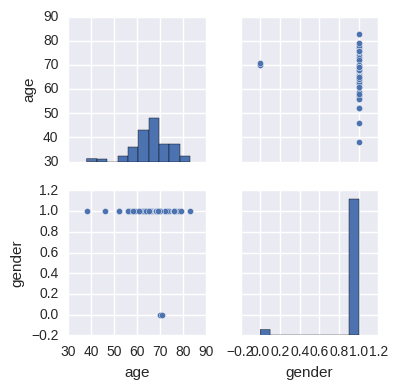

In [37]:
sns.pairplot(rbd.dropna(how='any'), vars=rbd.columns, size=2)